# ECON 407: Problem Set 5
<b>Professor Peifan Wu</b>

<b>Jack (Quan Cheng) Xie</b> <br>
Student #: 31091325

December 6, 2020

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

from numba import njit
import pandas as pd

Consider an income fluctuation problem similar to what we have in class. The agent receives a exogenous stochastic income $y$ every period where $y$ follows a Markov process. Moreover, she can choose how much asset that she will bring into the next period. Therefore, we can formulate the agent's Bellman equation as

$$
\begin{align*}
 & \max\sum_{t=0}^{\infty}\beta^{t}u\left(c_{t}\right)\\
\text{s.t.} & c_{t}+a_{t+1}\leqslant y_{t}+Ra_{t}
\end{align*}
$$

For the benchmark model, we assume the following parameter values: $\beta = 0.96$, $R = 1.01$.
We also assume that the households just use a CRRA preference: $u(c)=\frac{c^{1-\gamma}}{1-\gamma}$, where $\gamma = 1.5$.

For the endowment process, we assume that $y$ is Markov, and $y$ could take 3 values: $y=\left[0.0, 0.25, 0.5\right]$. The Markov transition matrix for $y$ is

$$
\left[\begin{array}{ccc}
0.7 & 0.2 & 0.1\\
0.15 & 0.7 & 0.15\\
0.1 & 0.2 & 0.7
\end{array}\right]
$$

In [2]:
# setup

# transition matrix
P = np.array([
    [0.7, 0.2, 0.1],
    [0.15, 0.7, 0.15],
    [0.1, 0.2, 0.7]
])

# endowment grid
y_grid = np.array([0.0, 0.25, 0.5])

n = len(y_grid) # states

# discount factor
β = 0.96

# risk free rate
R = 1.01

@njit
def u(c, γ=1.5):
    '''
    Utility function
    '''
    
    if γ == 1.0: # limit as γ -> 1
        res = np.log(c)
    else:
        res = (c ** (1 - γ)) / (1 - γ)
    
    # for nan values
    res[np.isnan(res)] = -1e10
    
    return res

## Q1 Solve a less constrained model

We set a capital grid $a\in\left[0.01,8.0\right]$ (you can divide the interval into a grid with 1000 evenly spaced points). This means the lowest asset position that the agents can take is $0.01$, which means we have a borrowing constraint $a_{t+1}\geqslant 0.01$.

Solve the model, and plot the consumption decision functions conditional on the combination of current asset position and endowment level.

**Use your own words to explain/summarize what you have found.**

In [3]:
# capital constraints

@njit
def solve_model(
            k_min=0.01, # minimum capital
            k_max=8.0, # maximum capital
            n_k=1000, # number of states
            ):
    '''
    Solve income fluctuation model
    '''
    
    # capital grid
    k_grid = np.linspace(k_min, k_max, n_k)

    V_prime = np.zeros((n, n_k)) # new iteration value
    V = V_prime.copy() # current iteration value

    consumption = np.zeros((n, n_k))

    policy = np.zeros((n, n_k))

    while True:

        for i in range(n): # endowment state index

            for j in range(n_k): # current period capital state index

                # consumption = current capital after interest + current income - next period capital
                c = R * k_grid[j] + y_grid[i] - k_grid

                # value_grid = current utility from consumption + discounted expected future value
                v_grid = u(c) + β * (P[i] @ V)

                # optimal value index
                k = np.argmax(v_grid)

                # value-to-go given income and capital
                V_prime[i, j] = v_grid[k]

                # policy = optimal next period capital
                policy[i, j] = k_grid[k]

                # consumption as result of policy
                consumption[i, j] = c[k]
                
                # impose natural non-negative consumption constraint
                if consumption[i, j] < 0:
                    # maximize consumption by minimizing next period capital
                    consumption[i, j] = c[0]
                    policy[i, j] = k_min

        # check convergence
        diff = np.abs(V - V_prime).sum()
        if diff < 1e-4:
            
            # return results
            return k_grid, V, policy, consumption

        else:
            # start new period
            V = V_prime.copy()

In [4]:
%%time

# solve model
res1 = solve_model()

k_grid_1, V_1, policy_1, consumption_1 = res1

Wall time: 22.6 s


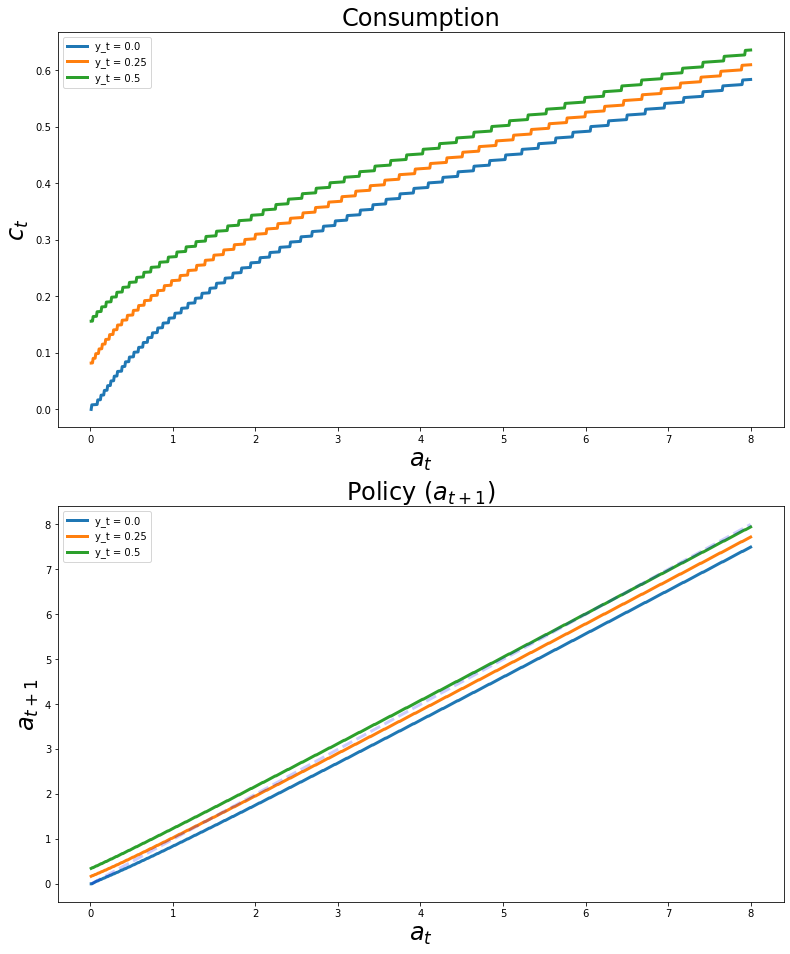

In [5]:
fig, axes = plt.subplots(2, figsize=(13, 16))

# plot consumption policy
axes[0].plot(k_grid_1, consumption_1.T, lw=3)

axes[0].set_title('Consumption', fontsize=24)
axes[0].set_xlabel('$a_t$', fontsize=24)
axes[0].set_ylabel('$c_t$', fontsize=24)
axes[0].legend([f'y_t = {y}' for y in y_grid])


# plot next period capital policy
axes[1].plot(k_grid_1, policy_1.T, lw=3)

# k = k' line
axes[1].plot(k_grid_1, k_grid_1, 'b--', alpha=0.2, lw=3)

axes[1].set_title('Policy ($a_{t+1}$)', fontsize=24)
axes[1].set_xlabel('$a_t$', fontsize=24)
axes[1].set_ylabel('$a_{t+1}$', fontsize=24)
axes[1].legend([f'y_t = {y}' for y in y_grid])

plt.show()

The plots show the optimal consumption and next period capital policy for the agent given his current period endowment/income (with three different realizations, one for each line) and capital (x-axis). In the model, we imposed a non-negative constraint for consumption.

Consumption increases with capital and income. The consumption policy is roughly concave, meaning the marginal optimal consumption is decreasing with capital. The more capital the agent has, the the rate at which his consumes more decreases.

For the capital policy function, the slope is slightly flatter than the 90-degree line, meaning as agent's capital increases, the agent maintains less of his capital for the next period. When his capital is low, he tries to save more capital for the next period than he has currently (unless his income is zero/negative). The more capital he has, the lower the ratio between his next-period capital and current capital $\frac{a_{t+1}}{a_t}$.

---

## Q2 Solve a more constrained model

Now we change the capital grid into $a\in\left[2.0,8.0\right]$. This implies that the lowest capital point that the agent can choose is $2.0$, which means the "borrowing constraint" is tighter for her.

Solve this model and compare the consumption functions with what you got from the last question. **Use your own words to describe the difference between these two.**

In [6]:
%%time

# solve more constrained model
res2 = solve_model(2, 8)

k_grid_2, V_2, policy_2, consumption_2 = res2

Wall time: 22.2 s


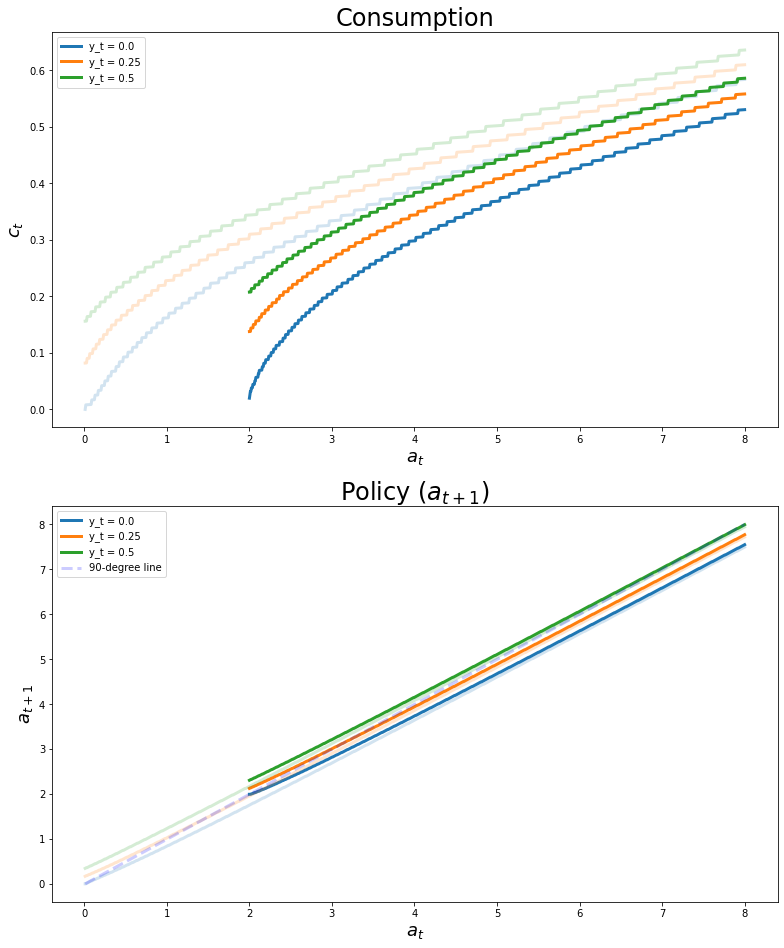

In [7]:
# default plot colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axes = plt.subplots(2, figsize=(13, 16))

for i in range(3):
    
    # plot consumption policy in new economy
    axes[0].plot(k_grid_2, consumption_2[i], c=colors[i], lw=3, label=f'y_t = {y_grid[i]}')
    
    # plot consumption policy in old economy
    axes[0].plot(k_grid_1, consumption_1[i], alpha=0.2, c=colors[i], lw=3)

axes[0].set_title('Consumption', fontsize=24)
axes[0].set_xlabel('$a_t$', fontsize=18)
axes[0].set_ylabel('$c_t$', fontsize=18)
axes[0].legend()


# plot old policy
for i in range(3):
    
    # plot next period capital policy in new economy
    axes[1].plot(k_grid_2, policy_2[i], c=colors[i], lw=3, label=f'y_t = {y_grid[i]}')
    
    # plot next period capital policy in old economy
    axes[1].plot(k_grid_1, policy_1[i], alpha=0.2, c=colors[i], lw=3)
    

# k = k' line
axes[1].plot(k_grid_1, k_grid_1, 'b--', alpha=0.2, lw=3, label='90-degree line')

axes[1].set_title('Policy ($a_{t+1}$)', fontsize=24)
axes[1].set_xlabel('$a_t$', fontsize=18)
axes[1].set_ylabel('$a_{t+1}$', fontsize=18)
axes[1].legend()

plt.show()

With a stronger borrowing constraint from increasing the minimum capital, near the capital lower-bound the agent consumes less given his current period capital and increases his savings for next period, but the policy functions converge with the two different constraints as capital increases.

Greater restrictions on borrowing also imposes restricts the agent's consumption policy, especially in low-capital states. Given his utility function, he would sometimes like to consume more in the low-capital states (reducing his next-period capital further), but is unable to due to his borrowing constraint.

---

## Q3 Stochastic Discount Factor

Consider one agent with asset $3.0$ who currently also receive an endowment $0.25$. Compute the stochastic discount factor for the two economies above, and compare them:

1. Notice that the endowment may have 3 realizations next period, so the stochastic discount factor may take three different values in either of the two economies above;
2. Describe your observations while comparing these two sets of results (3 numbers vs another set of 3 numbers);
3. Guess what does that mean for asset pricing, and try to rationalize it with some economic intuition

Derivative of utility function:
$$
\begin{align}
    u(c) = \frac{c^{1 - \gamma}}{1 - \gamma} \\
    u'(c) = c^{- \gamma} \\
\end{align}
$$

Stochastic discount factor:
$$
\begin{align}
    m_t 
    &= \beta\frac{u'(c')}{u'(c)} = \beta\left(\frac{c'}{c}\right)^{- \gamma} = \beta\left(\frac{c}{c'}\right)^{\gamma}
\end{align}
$$

In [8]:
@njit
def SDF(
    solution_set,
    a_t=3, # capital
    y_t=0.25, # endowment
    γ = 1.5 # risk aversion
        ):
    '''
    Compute stochastic discount factor
    '''
    k_grid, V, policy, c_grid = solution_set
    i = np.searchsorted(y_grid, y_t) # endowment index
    j = np.searchsorted(k_grid, a_t) # capital index

    # current optimal consumption
    c = c_grid[i, j]
    k_prime = k_grid[j]

    # index for k_prime policy function
    k = np.searchsorted(k_grid, k_prime)
    
    # optimal consumption grid for next period
    c_prime = R * k_prime + y_grid - policy[:, k]

    m = β * (c / c_prime)**γ
    
    return m


In [9]:
# compute SDF
m1 = SDF(res1)
m2 = SDF(res2)

# display with pandas

df = pd.DataFrame({
    'SDF_{1, t}(a_t >= 0.01)' : m1,
    'SDF_{2, t}(a_t >= 2)' : m2
    }, index=y_grid)

df.index.name = 'y_{t+1}'

display(df)

,"SDF_{1, t}(a_t >= 0.01)","SDF_{2, t}(a_t >= 2)"
y_{t+1},,
0.00,1.110530,1.443511
0.25,0.960000,0.960000
0.50,0.840649,0.757721


The SDF in the more-constrained $(k \ge 0.01)$ case is higher in the low next-period income realization $(y_{t+1} = 0)$, and lower in the high income realization $(y_{t+1} = 0.5)$. For the middle case, $y_{t+1} = 0.25 = y_{t}$, the two cases have the same SDF (SDF$_{1, t} =$ SDF$_{2, t} = \beta$).

In the middle case where income is the same $y_{t+1} = 0.25 = y_{t}$ in both periods, both agents have the same marginal utility in this period and the next $u'(c_{t}) = u'(c_{t+1})$. In this case they simply discount the payoffs by the normal discount rate SDF $= \beta$.

When income decreases in the next period $y_{t+1} = 0.00 < y_{t}$, agents' consumption policies decrease, therefore marginal utility for next period increases (since agents are risk averse). However, the marginal utility of the next-period consumption $u'(c_{t+1})$ is higher for the agent with a more-restrictive borrowing-constraint since his consumption policy is less $c_{2, t+1} < c_{2, t+1}$, especially in a low capital state $a_t = 3.0$. Therefore the more-constrained agent values future payoffs more in a lower endowment state.

When income increases in the next period $y_{t+1} = 0.50 > y_{t}$, agents' consumption increases, therefore marginaly utility for next period decreases. The more-constrained agent saves more capital for next period $a_{2, t+1} > a_{1, t+1}$ because of his borrowing constraint, which has an effect of increasing his consumption for his next period, which leads to lower ratio of marginal utility in the next period to this period than the less-constrained agent $\frac{u'(c_{2, t+1})}{u'(c_{2, t})} < \frac{u'(c_{1, t+1})}{u'(c_{1, t})}$. Therefore the more-constrained agent values future payoffs less in a higher endowment state.

Given the same asset, the more-constrained agent values lower-payoff states more and higher-payoff states less, behaving like a less risk-averse agent. The more-constrained agent will have a lower risk premium.

In [10]:
# state-persistent transition matrix used in class
Pi = np.array([
    [0.5, 0.25, 0.25],
    [0.25, 0.5, 0.25],
    [0.25, 0.25, 0.5]
])

@njit
def asset_price(
        solution_set,
        a_t=3, # capital
        γ = 1.5 # risk aversion
        ):
    '''
    Price asset given agent policy function and current capital state
    '''
    n = len(y_grid)
    
    m = np.zeros((n, n))
    
    for j, y in enumerate(y_grid):
        m[j] = SDF(solution_set, y_t=y, a_t=a_t, γ=γ)

    P = np.zeros(n)
    while True:
        
        P_prev = P.copy()
        for j in range(n):
            # price
            P[j] = np.dot(Pi[j], m[j] * (y_grid + P_prev))

        if np.max(np.abs(P - P_prev)) < 1e-10:
            break
            
    return P, m

In [12]:
%%time

P1, m1 = asset_price(res1)
P2, m2 = asset_price(res2)

print('Less constrained prices:', P1)
print('More constrained prices:', P2)

Less constrained prices: [4.69423428 5.50924885 6.35915999]
More constrained prices: [3.38462147 5.16825933 6.60583747]
Wall time: 1 ms
